In [290]:
import rpy2.rinterface
import rpy2.robjects as robjects

import numpy as np
import pandas as pd

from statsmodels.compat import lzip
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.api import plot_leverage_resid2, influence_plot, plot_ccpr_grid
# https://www.statsmodels.org/stable/examples/notebooks/generated/formulas.html
import seaborn as sns
sns.set_theme(style="whitegrid")
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
%load_ext rpy2.ipython

sns.set_theme(color_codes=True)
sns.set_context("poster")

In [9]:
%%R -o df
df = carData::Leinhardt

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105 entries, Australia to Zaire
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   income  105 non-null    int32   
 1   infant  101 non-null    float64 
 2   region  105 non-null    category
 3   oil     105 non-null    category
dtypes: category(2), float64(1), int32(1)
memory usage: 6.6+ KB


This database contains the following variables:
- **income** - per-capita income in U. S. dollars.
- **infant** - infant-mortality rate per 1000 live births
- **region** – a factor with levels: Africa; Americas; Asia, Asia and Oceania; Europe
- **oil** - oil-exporting country; a factor with levels: no, yes.

Specify a linear model that shows the impact of income, region and oil-exporting on the infant-mortality rate. 

In [10]:
model0 = smf.ols(formula='infant ~ income + region + oil', 
                 data=df).fit()
model0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 infant   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     8.556
Date:                 Вс, 24 янв 2021   Prob (F-statistic):           1.01e-06
Time:                        22:13:23   Log-Likelihood:                -579.41
No. Observations:                 101   AIC:                             1171.
Df Residuals:                      95   BIC:                             1187.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            136.8247     13.626     10.042      0.000     109.774     163.875
region[T.Americas]   -83.6494     21.798     -3.837      0.000    -126.925     -40.374
region[T.Asia]       -45.8854     20.144     -2.278      0.025     -85.876      -5.894
region[T.Europe]    -101.4862     30.728     -3.303      0.001    -162.489     -40.483
oil[T.yes]            78.3351     28.910      2.710      0.008      20.942     135.728
income                -0.0053      0.007     -0.714      0.477      -0.020       0.009
==============================================================================
Omnibus:                      103.771   Durbin-Watson:                   2.286
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1613.644
Skew:                           3.287   Prob(JB):                         0.00
Kurtosis:                      21.445   Cond. No.                     8.16e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

https://www.statsmodels.org/stable/diagnostic

# 1. Test the distribution of residuals
Comment on your results

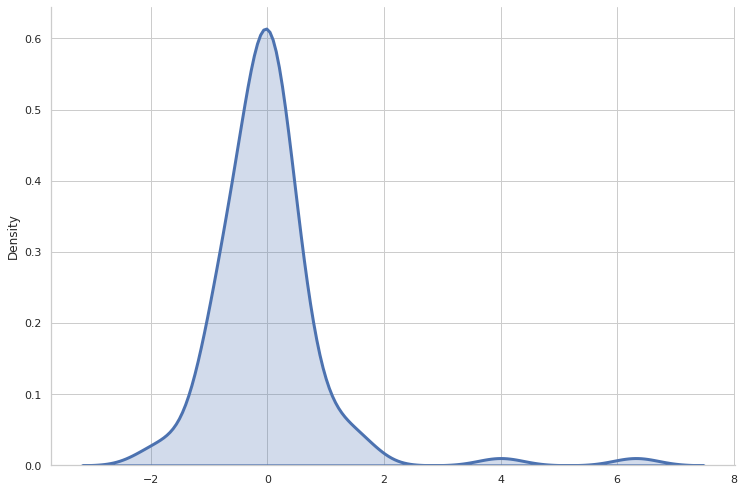

In [160]:
# norm = np.random.normal(np.mean(model0.resid), np.std(model0.resid), 10000)
# sns.displot(norm, kind="kde", fill=True,
#             linewidth=3, height=7, aspect=12/8)
sns.displot(model0.resid_pearson, kind="kde", fill=True,
            linewidth=3, height=7, aspect=12/8);
# plt.show()

Main part of the distribution looks quite normal but there is **positive skewness** - with it I can't say that such distribution is close to normal.

In [127]:
model0.summary().tables[2]

Omnibus:,103.771,Durbin-Watson:,2.286
Prob(Omnibus):,0.000,Jarque-Bera (JB):,1613.644
Skew:,3.287,Prob(JB):,0.00
Kurtosis:,21.445,Cond. No.,8.16e+03


As can be seen from the model summary table:
- **Jarque-Bera** p-value indicates **non-normal distributed** residuals
- **Omnibus** p-value too indicated **non-normal distributed** residuals

Therefore this distribution can't be considered as normal and regression assumption violated by such data.

# 2. Test for outliers, leverages and Cook’s distance
Are there any observations that might be outliers or/and affect the regression coefficients significantly? Justify your decision.

## Outliers

In [148]:
model0.outlier_test()[model0.outlier_test()['bonf(p)']<.05]

,student_resid,unadj_p,bonf(p)
Saudi.Arabia,9.581318,1.427193e-15,1.441464e-13
Afganistan,4.476714,2.127179e-05,2.148451e-03


Bonferroni p-value is lower than 0.05 only for two observations:
- **Saudi Arabia**
- **Afganistan**

Therefore this two observations can be considered as outliers.

## Leverages (by alike two plots)

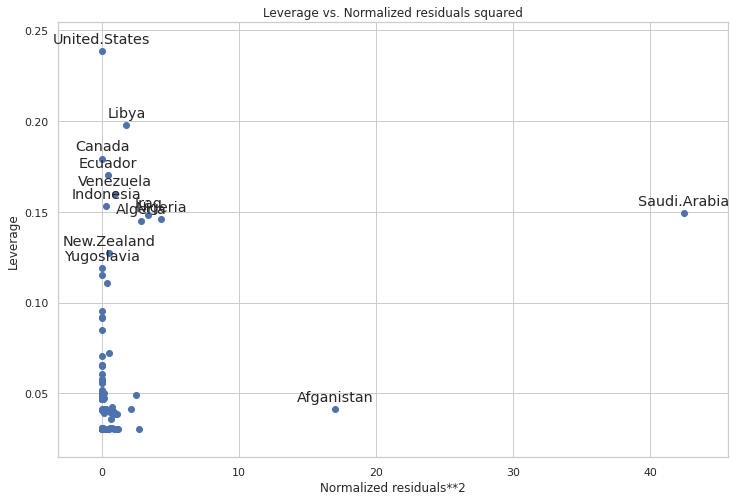

In [255]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(12, 8))
    plot_leverage_resid2(model0);

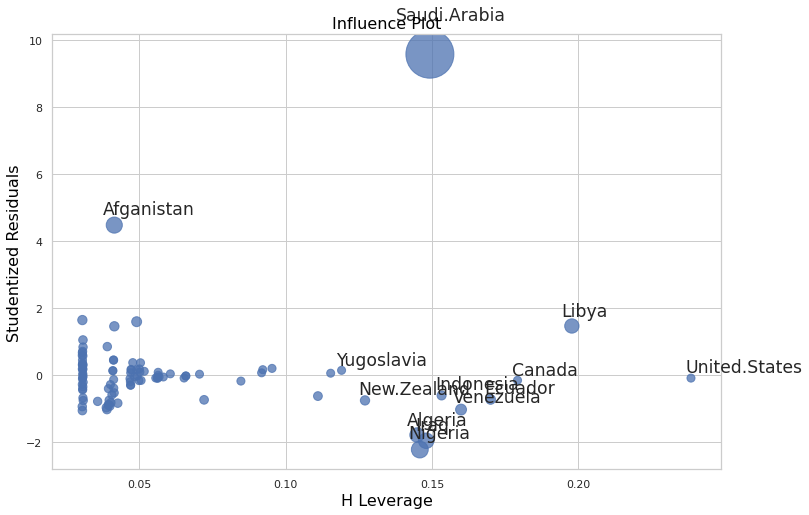

In [256]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(12, 8))
    influence_plot(model0);

Again, leverages show the same point - the most strange observations are on **Saudi Arabia** and **Afganistan**.

## Cook's distance (by tiny plot and deriving the name)

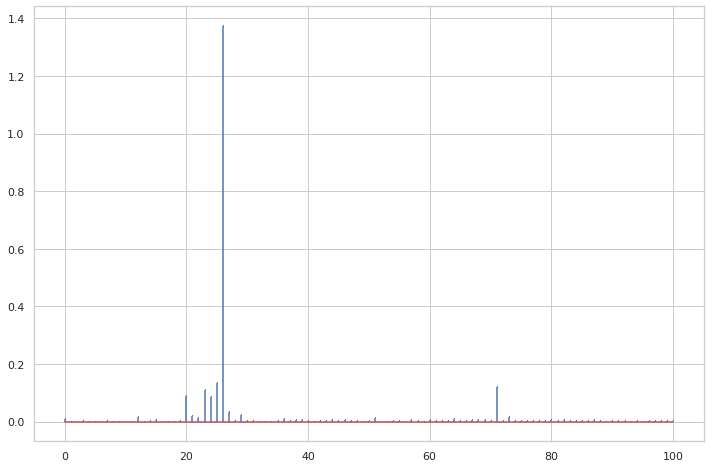

In [257]:
(c, p) = model0.get_influence().cooks_distance
with mpl.rc_context():
    mpl.rc("figure", figsize=(12, 8))
    plt.stem(np.arange(len(c)), c, markerfmt=",");

In [238]:
model0.outlier_test()[p==sorted(p)[0]].index[0]

'Saudi.Arabia'

And even by Cook's distance the worst ever observation is **Saudi Arabia**.

# 3. Test for the non-constant error variance (or heteroscedasticity)
Comment on your results

In [330]:
print(sms.het_breuschpagan(model0.resid, df[['infant', 'income']].dropna())[1::2])

print(sms.het_goldfeldquandt(model0.resid, df[['infant', 'income']].dropna()))

(4.6895141889720366e-11, 9.189941704070783e-13)
(0.4603334699722799, 0.9959821402137536, 'increasing')


Both tests indicate **violation of homoscedasticity**.

# 4. Test for non-linear effects in your model
Should your variables be transformed, if yes, then how? Justify your opinion.  
Specify a new model if necessary. Any difference in the results of the models?

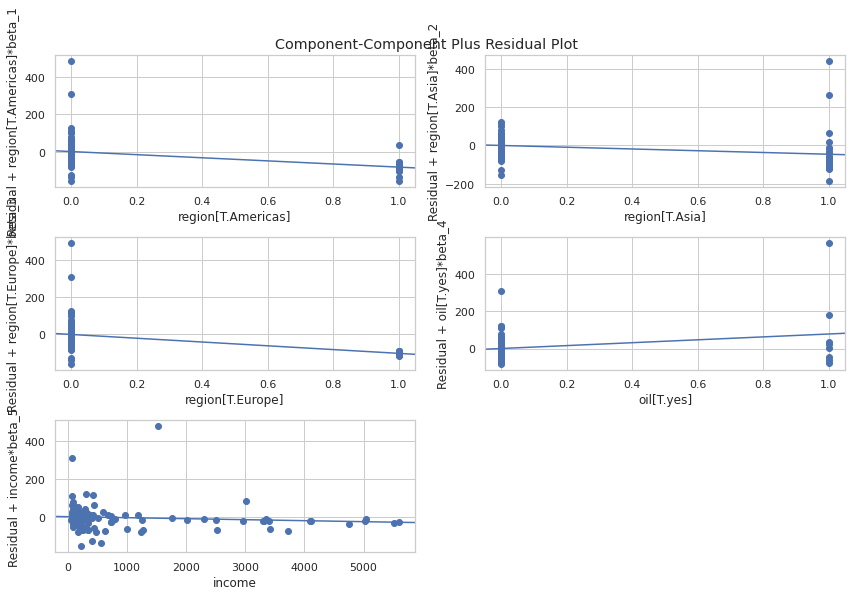

In [259]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(12, 8))    
    plot_ccpr_grid(model0);

At the qqplots for all predictors only one with numeric **income** is meaningful and it more looks like linear relationship. 

# 5. Test for multicollinearity (your new model, if specified)
Comment on your results.

In [297]:
X = add_constant(df[['infant', 'income']].dropna())
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], 
          index=X.columns)

const     3.188998
infant    1.122665
income    1.122665
dtype: float64

As can be seen by VIFs values there is no multicollinearity for the numeric variables.